# **Common approach to download a dataset from kaggle**

I have done this project in colab notebook mainly. Then I have uploaded the file to the kaggle.

# **Abstract**
1. I have tried to use two types of model
one is sklearn based fine tuned algorithm. Using tfidfvectorization for converting text into vector and train naive bayes model.

2. Tokenize the text into vector using keras API and create a LSTM architechture to train on my custom dataset.

Tfidf+naive bayes provide 93 % accuracy where LSTM privides better result in this case around 96 % accuracy.


In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d emineyetm/fake-news-detection-datasets

100% 41.0M/41.0M [00:02<00:00, 18.0MB/s]
100% 41.0M/41.0M [00:02<00:00, 14.7MB/s]


In [3]:
!unzip /content/fake-news-detection-datasets.zip

Archive:  /content/fake-news-detection-datasets.zip
  inflating: News _dataset/Fake.csv  
  inflating: News _dataset/True.csv  


# **Import necessary libraries**

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

# **Load the data**

In [2]:
true_df = pd.read_csv("/content/News _dataset/True.csv")

# **preprocessing**

In [3]:
#replace all the labels with real

true_df['subject'] = true_df['subject'].replace({'politicsNews':'real','worldnews':'real'})

In [4]:
true_df['subject'].value_counts()

real    21417
Name: subject, dtype: int64

In [5]:
#read the fake news

fake_df = pd.read_csv("/content/News _dataset/Fake.csv")

In [6]:
#available categories in fake news set

fake_df['subject'].value_counts().index

Index(['News', 'politics', 'left-news', 'Government News', 'US_News',
       'Middle-east'],
      dtype='object')

In [7]:
#replace all the category with fake

fake_df['subject'] = fake_df['subject'].replace({'News':'fake','politics':"fake","left-news":"fake","Government News":"fake","US_News":"fake","Middle-east":"fake"})

In [8]:
fake_df['subject'].value_counts()

fake    23481
Name: subject, dtype: int64

In [9]:
#concate real news set and fake news set and shuffle randomly

combined_df = pd.concat([true_df,fake_df])
new_df = combined_df.sample(frac=1).reset_index(drop=True)

In [10]:
#overview of the dataset

new_df.head()

,title,text,subject,date
0,WOW! Just When We Thought Obama’s Global Relat...,Weak leadership has repercussions The European...,fake,"Oct 30, 2015"
1,NEVER BEFORE SEEN: FBI Trove of 9/11 Pentagon ...,21st Century Wire says The FBI released 27 ne...,fake,"March 31, 2017"
2,BREAKING: [Video] Obama’s State Dept Miraculou...,What a great time for Joe Biden to announce. H...,fake,"Oct 20, 2015"
3,U.S. envoy Haley makes emotional visit to Cong...,"KITCHANGA, Democratic Republic of Congo (Reute...",real,"October 26, 2017"
4,Turkey's Justice Ministry says it canceled del...,ISTANBUL (Reuters) - Turkey s Justice Ministry...,real,"October 24, 2017"


In [11]:
# Drop unused column

new_df.drop(['date'],axis=1,inplace=True)

# **Format new dataset**

In [12]:
# create a new column

new_df['news'] = new_df['title'] + ' ' +new_df['text']

In [13]:
new_df.drop(['title','text'],inplace=True,axis=1)

In [14]:
new_df['subject'].value_counts()

fake    23481
real    21417
Name: subject, dtype: int64

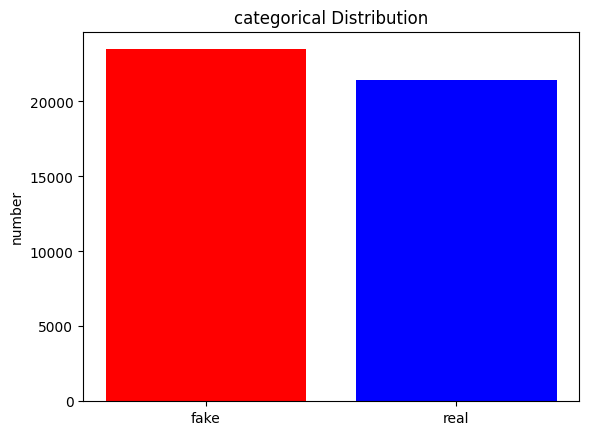

In [15]:
# check the balanceness of the label through visualization
import matplotlib.pyplot as plt
index = new_df['subject'].value_counts().index
value = new_df['subject'].value_counts().values

# plot the categorical distribution

plt.bar(index,value,color=['r','b'])
plt.title("categorical Distribution")
plt.ylabel("number")
plt.show()

# **Tfidf vectorization**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(stop_words="english",max_features=15000)
X = tf.fit_transform(new_df['news']).toarray()

# **Encoding label from categorical to numeric**

In [17]:
from sklearn.preprocessing import LabelEncoder # using labelencoding method
lbl = LabelEncoder()
new_df['subject'] = lbl.fit_transform(new_df['subject'])

# **separate target and feature**

In [18]:
import numpy as  np
X = np.array(X)
y = np.array(new_df['subject'])

# **split train and test set**

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# **Naive bayes calssifier**

In [20]:
from sklearn.naive_bayes import MultinomialNB
ml = MultinomialNB()  # initialize the model
ml.fit(x_train,y_train) # fit the dataset into the model

MultinomialNB()

# **save the model**

In [33]:
import pickle

# Save the trained model to a file using pickle
model_file_path = '/content/News _dataset/fake-news-detector'
with open(model_file_path, 'wb') as file:
    pickle.dump(ml, file)

# Load the saved model back into memory
with open(model_file_path, 'rb') as file:
    loaded_model = pickle.load(file)


# **performance**

accuracy of the model :93.56 %
classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4703
           1       0.94      0.93      0.93      4277

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



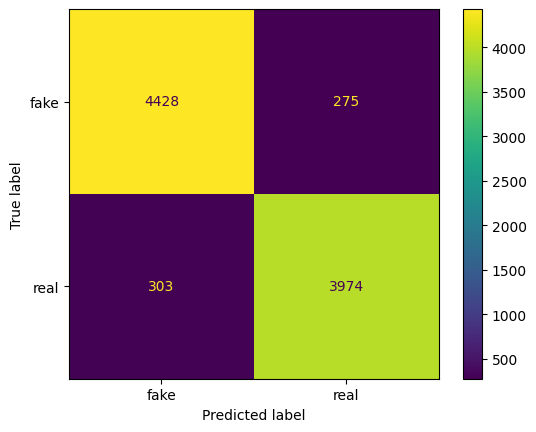

In [29]:
y_pred = ml.predict(x_test) #prediction

#performance report
print(f"accuracy of the model :{ml.score(x_test,y_test)*100:.2f} %")
print(f"classification report:\n{classification_report(y_test,y_pred)}")

#confusion matrix
cnf = confusion_matrix(y_test,y_pred)
plot = ConfusionMatrixDisplay(cnf,display_labels=['fake','real']).plot()
plt.show()

# **Time to shift in DL model**

In [34]:
#import necessary libraries under tenforflow framework

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM,GRU,Bidirectional,Embedding,Dense,Dropout
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential

# **text Preprocessing**

In [ ]:
import re

def clean_text(text):
    # Remove punctuation, symbols, and hyperlinks
    clean_text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and symbols
    clean_text = re.sub(r'http\S+', '', clean_text)  # Remove hyperlinks
    clean_text = clean_text.lower()  # Convert to lowercase
    return clean_text

new_df['news'] = new_df['news'].apply(clean_text)


In [ ]:
#over view

new_df['news']

0        us senate leader says iran sanctions renewal w...
1         conservatives are crying after meryl streep d...
2         richard spencers fascist goon squad couldnt k...
3        russia expresses deep concern about north kore...
4         breaking dakota access pipeline stopped by ar...
                               ...                        
44893    light aircraft crash kills 11 in tanzania dar ...
44894    germanys merkel says urgently need more sancti...
44895     trump has planted spies to ensure his cabinet...
44896     chris christie takes his family to closed bea...
44897     joe scarborough just eviscerated trumps attor...
Name: news, Length: 44898, dtype: object

# **Tokenization**

In [ ]:
tk = Tokenizer()  #initialize the tokenizer

tk.fit_on_texts(new_df['news'])
seq = tk.texts_to_sequences(new_df['news'])

In [ ]:
# convert into vector where each vector size will be 200
vector = pad_sequences(seq,padding='post',maxlen=200)

# **convert feature vector and label into numpy array **

In [ ]:
X = np.array(vector)
y = np.array(new_df['subject'])

# **split train and test set**

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# **Design the model using LSTM architecture**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=200,input_length=200))
model.add(LSTM(units=128))
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
#model compilation

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# train the model with 2 epochs only
history = model.fit(x_train,y_train,epochs=2,validation_data=(x_test,y_test),batch_size=16)

Epoch 1/2
2245/2245 [==============================] - 3184s 1s/step - loss: 0.1936 - accuracy: 0.9320 - val_loss: 0.3646 - val_accuracy: 0.8776
Epoch 2/2
2245/2245 [==============================] - 3156s 1s/step - loss: 0.1431 - accuracy: 0.9462 - val_loss: 0.0988 - val_accuracy: 0.9694


In [ ]:
#evaluate the model
model.evaluate(x_test,y_test)

281/281 [==============================] - 33s 116ms/step - loss: 0.0988 - accuracy: 0.9694


[0.09884213656187057, 0.9693763852119446]

In [ ]:
# Save the model to your desktop directory
model.save('C:/Users/DELL/Downloads/fake-news-detector.h5')

In [ ]:
from keras.models import load_model
saved_model = load_model("/content/News _dataset/fake-news-detector")

In [ ]:
y_pred_prob = saved_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

281/281 [==============================] - 32s 112ms/step


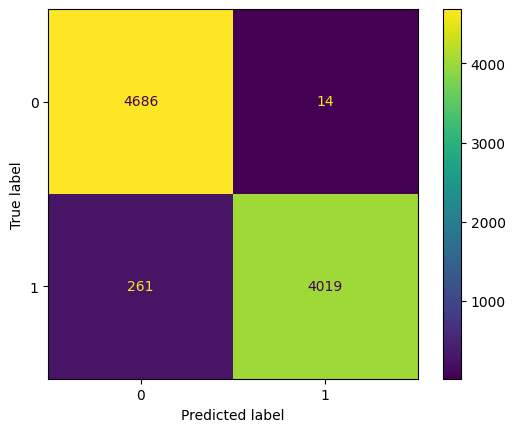

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(cnf).plot()
plt.show()